# Rotary Encodings in <img src="https://upload.wikimedia.org/wikipedia/commons/1/10/PyTorch_logo_icon.svg" style="height:0.75em"/>PyTorch

-----
In this notebook I examine the usage of Rotary Positional Encodings (RoPE) as presented by Su et al. ([2021](https://arxiv.org/pdf/2104.09864.pdf)). The actual "Encoder"-class `RoPEAttnLayer` containing the RoPE is in [./src/rope_attention_layer.py](./src/rope_attention_layer.py). Pre-compiled attention-kernels (like `torch.nn.functional.scaled_dot_product_attention`) can not be used, if one wants to stick to the exact configuration of the paper, because in the original encoding procedure described there the rotation have to be "inserted" in the attention mechanism itself . I do not want to show any fancy performance, just the setup. Any feedback is welcome. 

RoPEs are interesting not only because they are used e. g. in the [LLaMA](https://arxiv.org/abs/2302.13971)-model family, but also because recent work by Chen et al. ([2023](https://arxiv.org/abs/2306.15595)) shows, that the context windows of RoPE-based models can be extended very efficiently and with high performance by interpolation og the embedding function.

I used some general guidance for data loading and pre-processing as well as inspiration for the basic training loop by this [notebook from pytorch.org](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html). Additionally to parallelize the multi-head attention in a loop-free fashion I used the code from [this implementation of the transformer architecture by Andrej Karpathy](https://github.com/karpathy/nanoGPT/blob/master/model.py). I implemented just a basic encoder attention-layer without causal masking or similar building blocks.

### Setup

In [24]:
import numpy as np
import torch
from torch import nn
from torchtext import __version__ as torchtext_version
from torch.utils.data import DataLoader
from torchtext.datasets import IMDB
from torchtext.data.functional import to_map_style_dataset # Enable proper shuffeling
import matplotlib.pyplot as plt

from src import RoPEAttnLayer, build_vocab, preprocess_batch

print(f"Using torch version {torch.__version__}")
print(f"Using torchtext version {torchtext_version}")

Using torch version 1.13.1
Using torchtext version 0.14.1


In [2]:
## data path
from json import load, JSONDecodeError
with open("env.json", "r") as f:
    try:
        data_path = load(f)['data_path']
    except:
        raise JSONDecodeError("Error loading the data_path from env.json.")
    
# model and pipeline settings
vocab_size = 1000
batch_size = 64
epochs = 5
max_seqlen = 2048

# pytorch devices
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device.")

Using cuda device.


-----

### Data Preprocessing

In [3]:
# the usage of `to_map_style_dataset` is important to enable proper shuffeling
#  when constructing the DataLoaders
trn_rawpipe = to_map_style_dataset(IMDB(data_path, split="train"))
tst_rawpipe = to_map_style_dataset(IMDB(data_path, split="test"))

In [4]:
# building the vocab
#  saving time when running the notebook interactively
if 'vocab' not in locals():
    vocab = build_vocab(trn_rawpipe, vocab_size)

In [5]:
collate_batch = lambda batch: preprocess_batch(batch, vocab, max_seqlen, device)

trn_dataloader = DataLoader(trn_rawpipe, 
    batch_size=batch_size, drop_last=True, shuffle=True, 
    collate_fn=collate_batch
)
tst_dataloader = DataLoader(tst_rawpipe,
    batch_size=batch_size, drop_last=True, shuffle=True, 
    collate_fn=collate_batch
)

-----

### Defining the Model

In [6]:
vocab_size = len(vocab) + 1
d_model = 256
max_seqlen = max_seqlen
n_heads = 2
padding_value = vocab(["<pad>"])[0]

Checking that the layer works as expected and providing outputs of the same shape as the inputs:

In [7]:
embd = nn.Embedding(vocab_size, d_model, padding_idx=padding_value)
embd.to(device)

layer = RoPEAttnLayer(
    d_model=d_model, 
    n_heads=n_heads, 
    max_pos_enc_len=max_seqlen
)
layer.to(device)

batch = next(iter(trn_dataloader))
x = embd(batch['tokens'])

print("Applying RoPEAttnLayer:")
print(f"input shape: {x.shape}")
print(f"output shape: {layer(x).shape}")

del layer, embd

Applying RoPEAttnLayer:
input shape: torch.Size([64, 558, 256])
output shape: torch.Size([64, 558, 256])


Building an Encoder for sentiment classification around the `RoPEAttnLayer`, using 2 stacked attention layers.

In [8]:
class RoPEAttnEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding  = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=d_model, 
            padding_idx=padding_value
        )
        self.rope_attn1 = RoPEAttnLayer(
            d_model=d_model,
            n_heads=n_heads,
            max_pos_enc_len=max_seqlen
        )
        self.rope_attn2 = RoPEAttnLayer(
            d_model=d_model,
            n_heads=n_heads,
            max_pos_enc_len=max_seqlen
        )
        self.dense_out = nn.Linear(d_model, 1) 
        self.regularization_factor = np.sqrt(d_model)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.dense_out.bias.data.zero_()
        self.dense_out.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.embedding(x) * self.regularization_factor
        x = self.rope_attn1(x)
        x = self.rope_attn2(x)
        x = torch.mean(x, dim=1)    # Averaging over timesteps
        x = self.dense_out(x)
        return x.squeeze()

In [9]:
model = RoPEAttnEncoder().to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")
print("\nModel summary:\n--------------")
print(model)

The model has 781,825 trainable parameters

Model summary:
--------------
RoPEAttnEncoder(
  (embedding): Embedding(1001, 256, padding_idx=0)
  (rope_attn1): RoPEAttnLayer(
    (multi_head_in_projection): Linear(in_features=256, out_features=768, bias=False)
    (multi_head_out_projection): Linear(in_features=256, out_features=256, bias=False)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (rope_attn2): RoPEAttnLayer(
    (multi_head_in_projection): Linear(in_features=256, out_features=768, bias=False)
    (multi_head_out_projection): Linear(in_features=256, out_features=256, bias=False)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dense_out): Linear(in_features=256, out_features=1, bias=True)
)


-----
### "Testing" the Model

In [10]:
criterion = nn.BCEWithLogitsLoss()

In [11]:
## Testing one forward pass
test_batch = next(iter(trn_dataloader))
print(f"Tokens shape: {test_batch['tokens'].shape}")
print(f"Labels shape: {test_batch['labels'].shape}")

preds = model(test_batch['tokens'])
print(f"Output shape: {preds.shape}")
print(f"Loss: {criterion(preds, test_batch[ 'labels']):.2f}")

Tokens shape: torch.Size([64, 452])
Labels shape: torch.Size([64])
Output shape: torch.Size([64])
Loss: 0.83


-----

### Training

In [12]:
def correct_predictions(output, targets):
    preds = torch.round(torch.sigmoid(output))
    correct = (preds == targets).float()
    return correct.sum()

def run_train_loop(epochs: int, optimizer: torch.optim.Optimizer, model: nn.Module):

    def unpack_batch(batch):
        return batch['tokens'], batch['labels']

    def train_step(batch):
        model.zero_grad()
        tokens, labels = unpack_batch(batch)
        output = model(tokens)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        return (loss.detach().cpu().numpy(), 
                correct_predictions(output, labels)/batch_size)

    def eval_step(batch):
        tokens, labels = unpack_batch(batch)
        output = model(tokens)
        loss = criterion(output, labels).item()
        return float(loss), correct_predictions(output, labels)

    def evaluate():
        model.eval()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for k, batch in enumerate(tst_dataloader):
                loss, predictions = eval_step(batch)
                total_loss += loss
                correct_predictions += predictions
                total_predictions += batch_size

        return total_loss / k, correct_predictions / total_predictions

    history = {
        'batch_loss': [],
        'loss': [],
        'val_loss': []}

    for e in range(epochs):
        total_loss = 0
        model.train()
        for i, batch in enumerate(trn_dataloader):
            batch_loss, batch_accuracy = train_step(batch)
            history['batch_loss'].append(batch_loss)
            print(f"Batch = [{i}], loss = [{batch_loss:.2f}], acc = [{batch_accuracy:.2f}]", end="\r")
            total_loss += batch_loss
        val_loss, val_accuracy = evaluate()
        print(f"Epoch = [{e+1}], loss = [{val_loss:.2f}], acc = [{val_accuracy:.2f}]" + 4*" ")
        history['val_loss'].append(val_loss)
        history['loss'].append(total_loss / i)

    return history

In [13]:
optimizer = torch.optim.Adam(model.parameters(), 0.0001)
history = run_train_loop(epochs, optimizer, model)

Epoch = [1], loss = [0.36], acc = [0.84]    
Epoch = [2], loss = [0.34], acc = [0.85]    
Epoch = [3], loss = [0.33], acc = [0.85]    
Epoch = [4], loss = [0.33], acc = [0.86]    
Epoch = [5], loss = [0.33], acc = [0.86]    


-----

### Evaluating

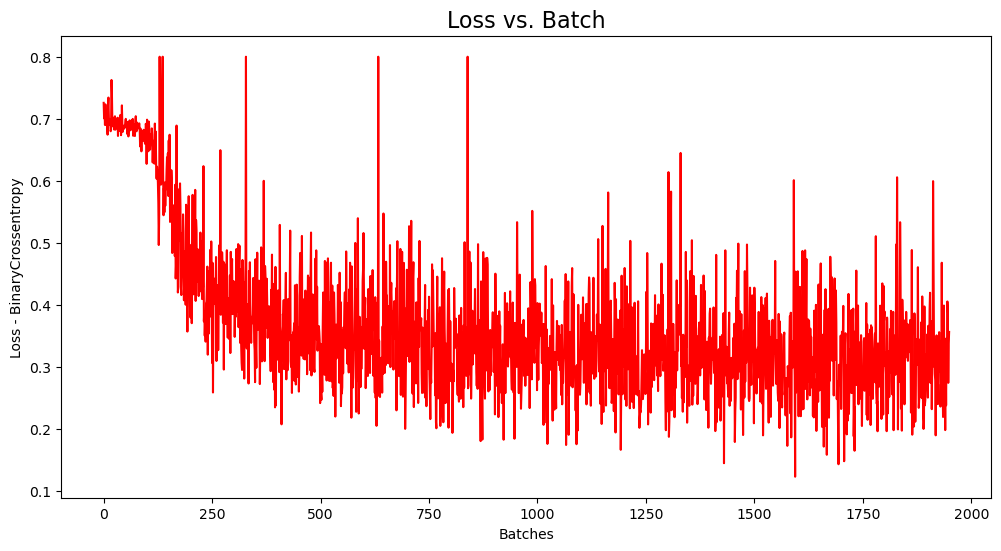

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Loss vs. Batch", fontsize=16)
ax.plot(np.clip(history['batch_loss'], a_min=-np.inf, a_max=0.8), "r-",) 
ax.set_xlabel("Batches")
ax.set_ylabel("Loss - BinaryCrossentropy")
plt.show()
plt.close()

In [16]:
epochs_arr = np.arange(epochs)
epochs_arr_val = epochs_arr + 1

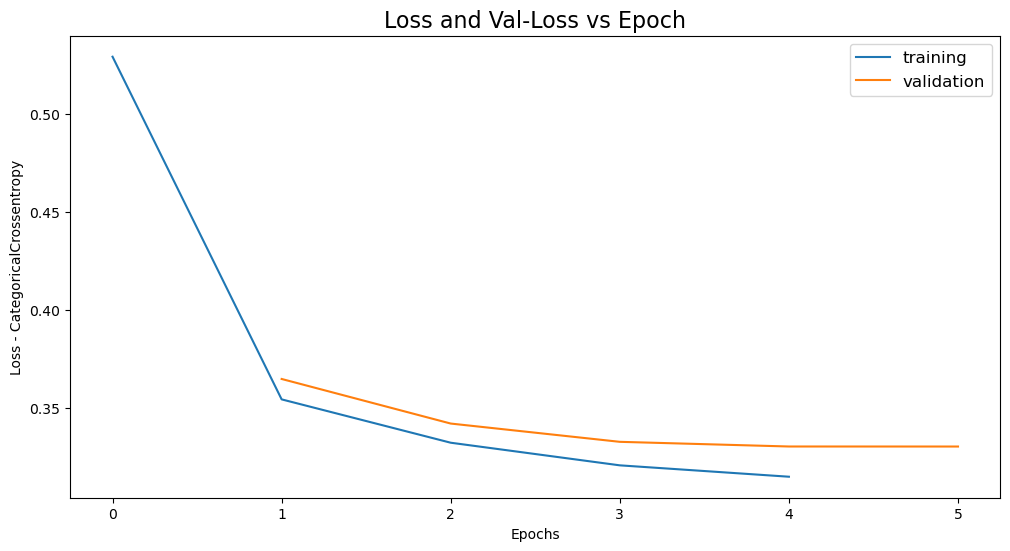

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Loss and Val-Loss vs Epoch", fontsize=16)
ax.plot(epochs_arr,     history['loss'], label=  "training") 
ax.plot(epochs_arr_val, history['val_loss'], label=  "validation") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss - CategoricalCrossentropy")
leg = ax.legend(frameon=True, fontsize=12)
plt.show()
plt.close()